In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import scipy.stats as sps
import scipy.stats as stats

In [2]:
df = pd.read_csv('skyeng_day2.csv')

In [3]:
df.describe()

,user,check
count,5.525700e+04,55257.000000
mean,1.070655e+09,303.292846
std,6.208896e+08,1692.534092
min,6.749916e+04,0.000000
25%,5.295924e+08,0.000000
50%,1.069357e+09,0.000000
75%,1.610061e+09,0.000000
max,2.147465e+09,81195.000000


In [4]:
df.sample(10)

,user,check
46142,1.792232e+09,0.0
21735,8.391302e+08,0.0
29468,1.140384e+09,0.0
33405,1.291979e+09,0.0
22688,8.777556e+08,6530.0
46868,1.819491e+09,0.0
52440,2.040352e+09,0.0
34153,1.322007e+09,0.0
33369,1.291093e+09,0.0
29576,1.144540e+09,0.0


<AxesSubplot:>

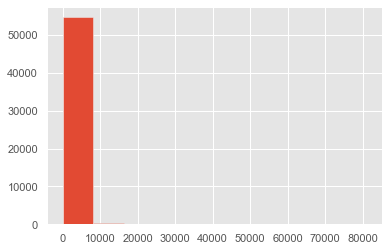

In [60]:
df.check.hist()

In [61]:
df['check'].value_counts()

0.0        52427
4144.0         4
4027.0         4
2025.0         3
3964.0         3
           ...  
5314.0         1
2213.0         1
19751.0        1
4425.5         1
8824.0         1
Name: check, Length: 2538, dtype: int64

Видим, что в данных очень много нулевых значений - 52 тыс из 55 тыс.

In [62]:
df['check'].mean(), df['check'].std()

(303.2928463362108, 1692.5340923518577)

Можно сказать, что сумма составляет где-то от 300 до плюс / минус 1692 рублей

c:\users\valer\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


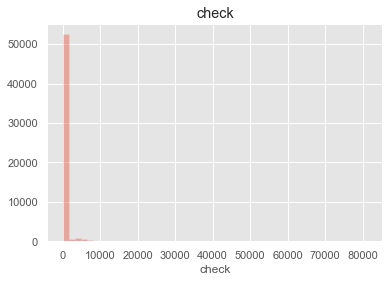

In [63]:
plt.figure()
sns.distplot(df['check'], kde = False, rug=False)
plt.title('check')
plt.show()

In [5]:
X = df.drop(['user'], axis=1)

In [6]:
Group_A, Group_B = train_test_split(X, test_size = 0.5, random_state=42) 

In [7]:
#Как оценить распределение разницы средних
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):

    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_2), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = sps.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = sps.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci,            
            "p_value": p_value}

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 390.97it/s]


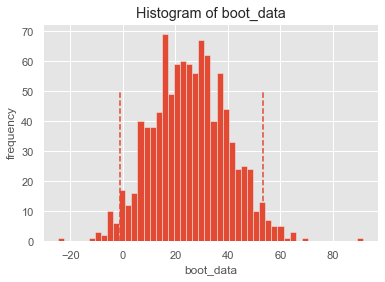

{'boot_data': [32.87801503203559,
  31.783041801221373,
  5.798091844281714,
  31.03897829289957,
  23.99038279008323,
  35.438739091649495,
  29.85964520046832,
  35.064690269375774,
  27.24213060266476,
  41.43100386477994,
  24.217452083636488,
  14.919776295360464,
  19.2182634963998,
  25.113747367580913,
  15.536634373538163,
  32.89314124946924,
  34.25005390241938,
  50.63670870461618,
  38.1738520763044,
  22.55436867857003,
  43.2409984615752,
  27.468501455402247,
  33.18217820786691,
  19.00521531066005,
  24.63522983020175,
  21.755428164702323,
  29.888281830221956,
  8.740569225336685,
  8.169327018720594,
  9.708294204713127,
  15.66999776704563,
  45.01763401164936,
  26.84471620757546,
  23.26106800863994,
  32.777052754738236,
  33.767285378003066,
  28.12291690123203,
  48.3453718654423,
  30.38466518366016,
  23.689168271726373,
  22.585787515098957,
  11.690277152081023,
  8.758030357528469,
  31.713364721392736,
  29.839228726847296,
  26.080630933080954,
  39.73

In [67]:
get_bootstrap(Group_A, Group_B,1000,np.mean,0.95)

Разница средних распределена нормально. Мы можем использовать t-тест

### Как оценить распределение pValue, t статистики и fpr

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.18it/s]


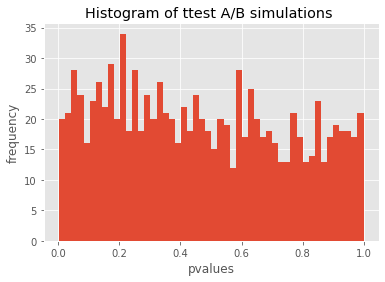

<0.05 0.049
<0.01 0.009
<0.1 0.106


In [14]:
#n = 100000
simulations = 1000
n_s = 1000
res = []
tt = []

#df = pd.DataFrame({
#    "s1": np.random.exponential(scale=1/0.001, size=n),
#    "s2": np.random.exponential(scale=1/0.001, size=n)
#})


# Запуск симуляций A/B теста
for i in tqdm(range(simulations)):
    s1 = Group_A['check'].sample(n_s, replace = False).values
    s2 = Group_B['check'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue
    tt.append(stats.ttest_ind(s1, s2, equal_var = False)[0])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/B simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
print("<0.05",sum(np.array(res) <0.05) / simulations)
print("<0.01",sum(np.array(res) <0.01) / simulations)
print("<0.1",sum(np.array(res) <0.1) / simulations)

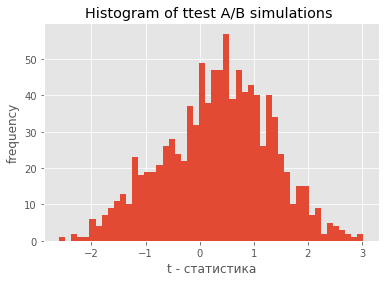

In [15]:
plt.hist(tt, bins = 50)
plt.style.use('ggplot')
plt.xlabel('t - статистика')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/B simulations ")
plt.show()

In [10]:
p_val = stats.ttest_ind(Group_A,Group_B).pvalue
p_val

array([0.07124269])

In [94]:
stats.ttest_ind(Group_A,Group_B)
#########Посмотреть statistic

Ttest_indResult(statistic=array([], dtype=float64), pvalue=array([], dtype=float64))

In [128]:
if p_val < 0.05: 
            print('группы А и B значимо различаются: %f' 
                  % (Group_A, Group_B, p_val))
else:
            print('группы А и B не различаются')

группы А и B не различаются


c:\users\valer\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

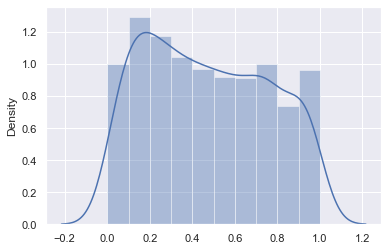

In [129]:
sns.set() #установим стандартные параметры отображения графиков
sns.distplot(res)

Посчитаем Метрику – ARPU

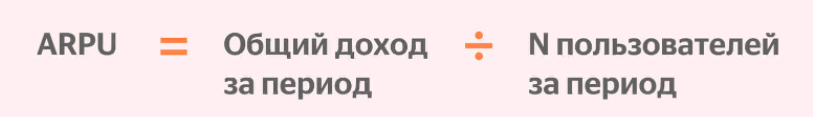

In [72]:
df_groupby_user = df.groupby(['check']).sum()
print("Количество уникальных user:",len(df_groupby_user))

Количество уникальных user: 2538


In [75]:
ARPU = df['check'].sum()/len(df_groupby_user)
ARPU

6603.251698187549

<b> Выводы </b>

Наша нулевая гипотеза – между наблюдениями в двух выборках не существует связи.

Гипотезу отвергают, если данные показывают разницу в
проверяемой показателе между выборками (на заданном
уровне значимости - 0.95)
Отвергнуть мы ее можем при заданной допустимости ошибки первого рода (p-value), т.е.
чтобы ошибка была меньше 0.05, если нам достаточно 95% уровня значимости.

У нас p_value - 0.07, что больше 0.05, а значит мы не можем отвергнуть нулевую гипотезу.

<b>1) Как распределена t статистика при верности нулевой гипотезы</b>

T-тест используется для проверки того, является ли разница между средними значениями для двух групп значимой.

График симметричен только при верности нулевой гипотезы, а если график смещен влево или вправо(смещен в сторону эффекта) значит нулевая гипотеза не верна.

У нас график симметричен, что подтверждает верность нулевой гипотезы.


<b>2) Как распределен pValue при верности нулевой гипотезы </b>
У нас на графике частота P-value примерно на одном уровне.

<b>3) Как распределена разница средних</b>

Разница средних распределена нормально.

### Вариант 2. Эксперимент. Уберем все значения с нулем.

In [3]:
df = pd.read_csv('skyeng_day2.csv')
df_new = df.loc[df['check']!=0]
X = df_new.drop(['user'], axis=1)
Group_A, Group_B = train_test_split(X, test_size = 0.5, random_state=42) 

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 652.43it/s]


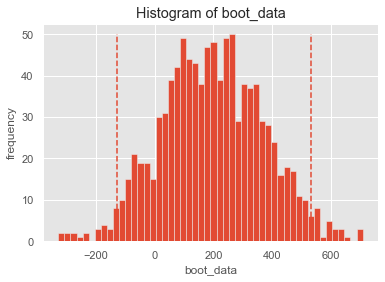

{'boot_data': [396.3640282685519,
  488.88148409893984,
  99.47043816254245,
  527.0054628975249,
  189.91961837455892,
  80.7104240282697,
  107.68270671378104,
  95.09309540635968,
  357.5205088339226,
  50.50836042402716,
  61.25455830388637,
  412.450579505301,
  132.68920141342824,
  88.9244593639578,
  50.89679858657291,
  393.5983321554768,
  61.55123674911829,
  224.19679151943456,
  340.77719434628943,
  -151.84425441696203,
  105.6772438162543,
  201.38115901060064,
  472.39013427561895,
  121.40835335689098,
  466.65906007067133,
  259.0603250883387,
  226.36423321554867,
  -32.49035335689223,
  78.95609893992878,
  330.76050176678564,
  359.2228268551253,
  423.07761837455837,
  372.29607773851694,
  230.7276819787985,
  219.01439575971654,
  263.9388480565376,
  344.89196466431076,
  102.65103180212009,
  85.92696819788034,
  462.6302614840979,
  487.09892579505413,
  -91.8748056537097,
  309.2614063604233,
  100.00218374558426,
  97.25269964664312,
  250.36722261484192,
 

In [138]:
get_bootstrap(Group_A, Group_B,1000,np.mean,0.95)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 675.62it/s]


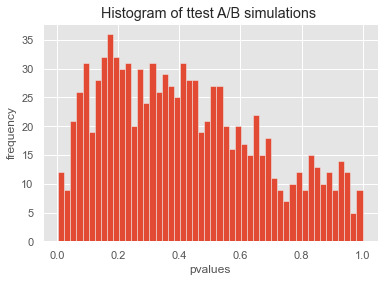

In [140]:
simulations = 1000
n_s = 1000
res = []
# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
   
    s1 = Group_A['check'].sample(n_s, replace = False).values
    s2 = Group_B['check'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/B simulations ")
plt.show()


p-value стал больше - 0.258

### Вариант 3 Сгруппирую данные по id пользователям

In [16]:
df = pd.read_csv('skyeng_day2.csv')

In [17]:
df_groupby_user = df.groupby(['check']).sum()
df_groupby_user

,user
check,
0.0,5.610121e+13
374.0,3.271398e+08
398.0,2.480423e+08
399.0,1.292495e+09
466.0,2.031502e+08
...,...
42126.0,8.666208e+08
51209.0,2.127409e+09
57662.0,3.531167e+08


In [18]:
X = df_groupby_user.drop(['user'], axis=1)

In [19]:
Group_A, Group_B = train_test_split(X, test_size = 0.5, random_state=42) 

In [20]:
Group_A_=Group_A.reset_index()

In [21]:
Group_B_=Group_B.reset_index()

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1342.94it/s]


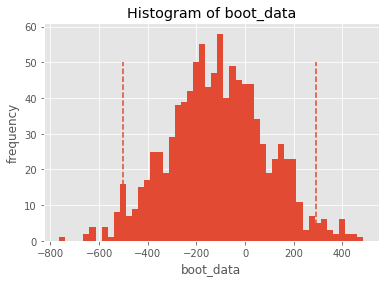

{'boot_data': [-66.91951930654068,
  53.23154452324707,
  -114.15936958234761,
  -109.98355397951127,
  217.86333333333278,
  -111.40368794326241,
  99.35030732860469,
  -186.5779275019695,
  -260.8246178092995,
  -125.7973758865237,
  -70.91025216706112,
  -225.70086682427063,
  48.38100078802108,
  -229.74848699763606,
  97.39748620961382,
  -251.63267139479922,
  116.25980299448383,
  -41.125350669819454,
  146.98564223798348,
  -508.9579905437349,
  -218.46483845547755,
  -272.51520882584737,
  -282.72321513002316,
  -75.50818754925149,
  77.03778565799803,
  -116.1437903861306,
  -81.77226950354634,
  133.5421118991335,
  -506.04917257683337,
  -284.3580929866048,
  -77.97700551615435,
  -21.65915681639126,
  -279.28598108746974,
  -221.19466509062295,
  -102.5110007880221,
  -357.17830575256085,
  -96.98996059889578,
  -245.43169424743974,
  -497.836477541372,
  -131.45634357761992,
  63.77640661938494,
  -407.34144996059877,
  35.35866036249081,
  61.09955082742272,
  27.9090937

In [22]:
get_bootstrap(Group_A_, Group_B_,1000,np.mean,0.95)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 657.09it/s]


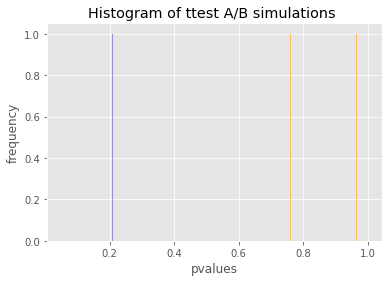

In [23]:
simulations = 1000
n_s = 1000
res = []
tt =[]
# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
   
    s1 = Group_A_.sample(n_s, replace = False).values
    s2 = Group_B_.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue
    tt.append(stats.ttest_ind(s1, s2, equal_var = False)[0]) # сохраняем t

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/B simulations ")
plt.show()

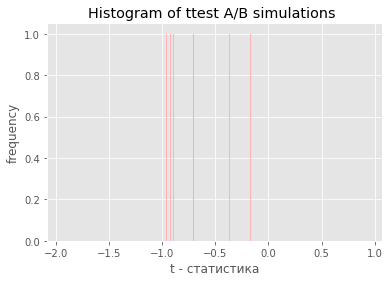

In [27]:
plt.hist(tt, bins = 50)
plt.style.use('ggplot')
plt.xlabel('t - статистика')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/B simulations ")
plt.show()

c:\users\valer\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

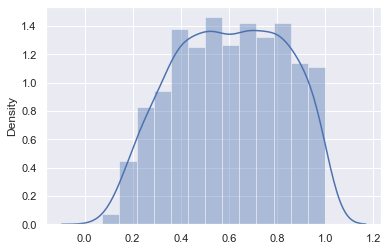

In [38]:
sns.set() #установим стандартные параметры отображения графиков
sns.distplot(res)

Это вариант тоже не улучшил показатели. При группировки слишком мало получается данных из выборок. 